In [1]:
import pandas as pd

RAW_PATH = "../data/diabetes.csv"
df_raw = pd.read_csv(RAW_PATH)

In [2]:
# separate features/target without any cleaning yet
X = df_raw.drop(columns=["Outcome"])
y = df_raw["Outcome"]

In [3]:
print("Raw shapes:", X.shape, y.shape)
print("Overall positive rate (Outcome=1):", y.mean())
X.head()

Raw shapes: (768, 8) (768,)
Overall positive rate (Outcome=1): 0.3489583333333333


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [4]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# columns that cannot be zero medically
invalid_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]


In [5]:
class ZeroToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X.loc[X[c] == 0, c] = np.nan
        return X


In [6]:
from sklearn.model_selection import train_test_split

X = df_raw.drop(columns=["Outcome"])
y = df_raw["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [7]:
preprocess = Pipeline([
    ("zero_to_nan", ZeroToNaN(invalid_zero_cols)),      # step 1: mark invalid zeros
    ("imputer", SimpleImputer(strategy="median")),      # step 2: fill missing with median
    ("scaler", StandardScaler())                        # step 3: normalize features
])


In [8]:
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

print("Train shape after preprocessing:", X_train_prep.shape)
print("Test  shape after preprocessing :", X_test_prep.shape)


Train shape after preprocessing: (614, 8)
Test  shape after preprocessing : (154, 8)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# train (fit) the model on preprocessed training data
log_reg.fit(X_train_prep, y_train)

# make predictions on test data
y_pred = log_reg.predict(X_test_prep)
y_proba = log_reg.predict_proba(X_test_prep)[:, 1]  # probability for ROC/AUC


In [10]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Model Evaluation Metrics")
print("---------------------------")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1 Score :", round(f1, 3))
print("AUC Score:", round(auc, 3))


Model Evaluation Metrics
---------------------------
Accuracy : 0.708
Precision: 0.6
Recall   : 0.5
F1 Score : 0.545
AUC Score: 0.813


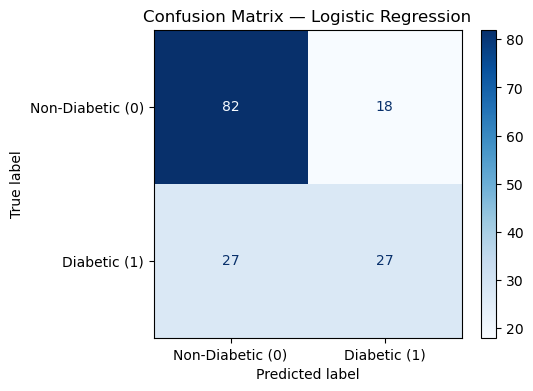

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Diabetic (0)", "Diabetic (1)"])

fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


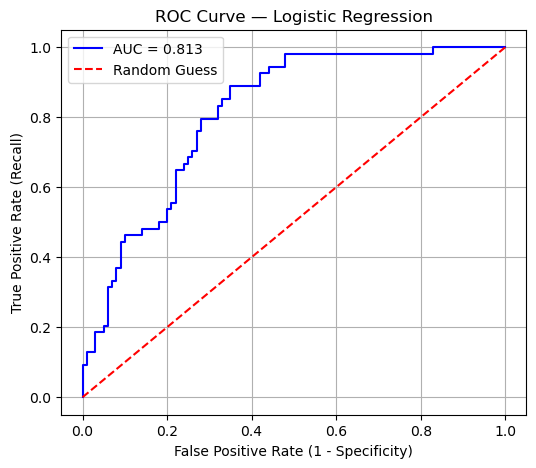

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# calculate false positive rate, true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# plot the ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "r--", label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# initialize the model
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # let it grow deep
    random_state=42
)

# train on the same preprocessed data
rf.fit(X_train_prep, y_train)

# make predictions
y_pred_rf = rf.predict(X_test_prep)
y_proba_rf = rf.predict_proba(X_test_prep)[:, 1]

# evaluate
acc = accuracy_score(y_test, y_pred_rf)
prec = precision_score(y_test, y_pred_rf)
rec = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Performance")
print("--------------------------")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"AUC Score: {auc:.3f}")


Random Forest Performance
--------------------------
Accuracy : 0.747
Precision: 0.660
Recall   : 0.574
F1 Score : 0.614
AUC Score: 0.818


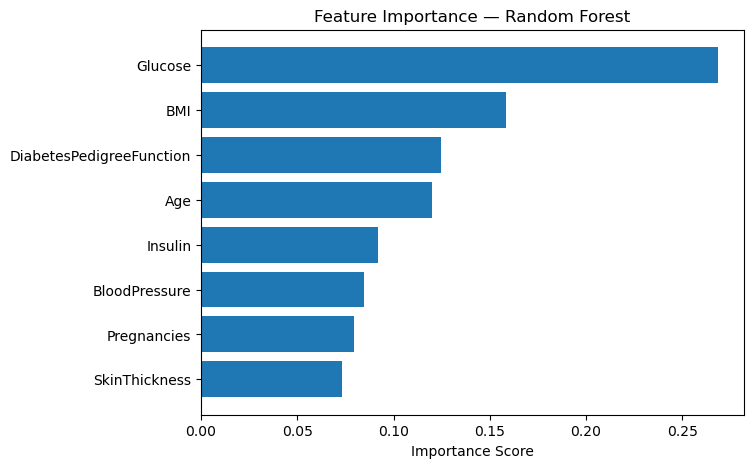

,Feature,Importance
1,Glucose,0.268413
5,BMI,0.158209
6,DiabetesPedigreeFunction,0.124501
7,Age,0.120028
4,Insulin,0.091665
2,BloodPressure,0.084635
0,Pregnancies,0.079267
3,SkinThickness,0.073282


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# get feature importance scores
importances = rf.feature_importances_
feature_names = X_train.columns

# create a dataframe for visualization
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# display top 10 features
plt.figure(figsize=(7,5))
plt.barh(feat_imp['Feature'][:10], feat_imp['Importance'][:10])
plt.gca().invert_yaxis()
plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance Score")
plt.show()

feat_imp


In [15]:
import joblib
import os

# create a folder for models
os.makedirs("../models", exist_ok=True)

# save both pipeline and model
joblib.dump(preprocess, "../models/preprocess.pkl")
joblib.dump(rf, "../models/random_forest_model.pkl")

print("✅ Model and preprocessing pipeline saved successfully!")


✅ Model and preprocessing pipeline saved successfully!


In [16]:
# collect all metrics
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [0.708, 0.747],
    "Precision": [0.600, 0.660],
    "Recall": [0.500, 0.574],
    "F1 Score": [0.545, 0.614],
    "AUC": [0.813, 0.818]
})

print("Model Comparison Summary\n")
display(results)


Model Comparison Summary



,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.708,0.60,0.500,0.545,0.813
1,Random Forest,0.747,0.66,0.574,0.614,0.818
